In [32]:
# importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import folium
import json
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker


In [2]:
# setting configurations
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
# linking google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# importing data
df = pd.read_csv('/content/drive/MyDrive/Iowa Liquor /Prepared Data/liquor_demo_college_dist_clean.csv', index_col=0)
df.head()

,date,store_name,address,city,zip_code,county,category_name,vendor_name,item_description,pack,bottle_volume_(ml),state_bottle_cost,state_bottle_retail,bottles_sold,sale_(dollars),volume_sold_(liters),unique_store,store_latitude,store_longitude,county_population,county_poverty_rate,county_median_earnings_(dollars),city_population,students_in_city,colleges_in_city,closest_college_kilometers,nearest_college,students_nearest_college,competitors_within_10_kilometers,competitors_within_5_kilometers,competitors_within_2_kilometers
0,07/04/2022,HY-VEE WINE AND SPIRITS / ANKENY,410 NORTH ANKENY BLVD,ANKENY,50021,POLK,IMPORTED VODKAS,DIAGEO AMERICAS,KETEL ONE,6,1750,20.99,31.49,6,188.94,10.5,"410 NORTH ANKENY BLVD, ANKENY, 50021",41.734504,-93.602470,501089,10.1,42262,72222,23555.0,2.0,1.849264,Faith Baptist Bible College and Theological Se...,504,42,31,14
1,07/04/2022,HY-VEE WINE AND SPIRITS / ANKENY,410 NORTH ANKENY BLVD,ANKENY,50021,POLK,AMERICAN FLAVORED VODKA,DIAGEO AMERICAS,"SMIRNOFF RED, WHITE & BERRY",6,1750,14.75,22.13,6,132.78,10.5,"410 NORTH ANKENY BLVD, ANKENY, 50021",41.734504,-93.602470,501089,10.1,42262,72222,23555.0,2.0,1.849264,Faith Baptist Bible College and Theological Se...,504,42,31,14
2,07/04/2022,HY-VEE WINE AND SPIRITS / HUBBELL,2310 HUBBELL AVE,DES MOINES,50317,POLK,COCKTAILS/RTD,PROXIMO,JOSE CUERVO AUTHENTIC LIME MARGARITA,6,1750,8.74,13.11,6,78.66,10.5,"2310 HUBBELL AVE, DES MOINES, 50317",41.604613,-93.574132,501089,10.1,42262,211034,9076.0,4.0,2.821928,Grand View University,1874,105,40,7
3,07/04/2022,UNIVERSITY LIQUORS / WDM,9250 UNIVERSITY AVE UNIT 115,WEST DES MOINES,50266,POLK,AMERICAN SCHNAPPS,JIM BEAM BRANDS,DEKUYPER HOT DAMN!,12,750,6.75,10.13,6,60.78,4.5,"9250 UNIVERSITY AVE UNIT 115, WEST DES MOINES,...",41.599689,-93.834562,501089,10.1,42262,70741,0.0,0.0,6.698595,Des Moines University-Osteopathic Medical Center,1559,94,36,6
4,07/04/2022,"CENTRAL CITY LIQUOR, INC.",1460 2ND AVE,DES MOINES,50314,POLK,IMPORTED VODKAS,JIM BEAM BRANDS,EFFEN 80PRF,6,750,12.50,18.75,6,112.50,4.5,"1460 2ND AVE, DES MOINES, 50314",41.605652,-93.620233,501089,10.1,42262,211034,9076.0,4.0,0.910683,Des Moines Area Community College,23051,132,49,9


In [10]:
# convert Date column to datetime format
df['date'] = pd.to_datetime(df['date'])

# extract year from Date column
df['year'] = df['date'].dt.year

# filter data for the years 2016 to 2022
df = df[(df['year'] >= 2016) & (df['year'] <= 2022)]

In [15]:
# filter the data for '100% AGAVE TEQUILA'
df = df[df['category_name'] == '100% AGAVE TEQUILA']

In [37]:
# saving data for Tableau visualisations
df.to_csv("/content/drive/MyDrive/Iowa Liquor /Prepared Data/tequila_sales_2016_2022.csv")

# 1. Creating Chloropleth Map for County Sales

### A. Merging JSON and Sales Data

In [17]:
# calculate total sales for each county
county_sales = df.groupby('county').agg({'sale_(dollars)': 'sum', 'county_population': 'mean'}).reset_index()

In [18]:
# import geijson file for iowa counties
iowa_map = gpd.read_file('/content/drive/MyDrive/Iowa Liquor /Raw Data/Iowa_County_Boundaries.geojson')

In [19]:
print(iowa_map.columns)

Index(['OBJECTID', 'PERIMETER', 'DOMCountyID', 'FIPS', 'FIPS_INT',
       'CountyName', 'StateAbbr', 'SHAPE_Length', 'SHAPE_Area', 'geometry'],
      dtype='object')


In [20]:
# convert county names to lowercase in both dataframes to ensure a successful merge
county_sales['county'] = county_sales['county'].str.lower()
iowa_map['CountyName'] = iowa_map['CountyName'].str.lower()

In [21]:
county_sales_counties = set(county_sales['county'].unique())
iowa_map_counties = set(iowa_map['CountyName'].unique())

# counties in county_sales but not in iowa_map
missing_in_iowa_map = county_sales_counties - iowa_map_counties
print("Missing in iowa_map:", missing_in_iowa_map)

# counties in iowa_map but not in county_sales
missing_in_county_sales = iowa_map_counties - county_sales_counties
print("Missing in county_sales:", missing_in_county_sales)

Missing in iowa_map: {"o'brien"}
Missing in county_sales: {'obrien'}


In [22]:
# changing name of o'brien
iowa_map['CountyName'] = iowa_map['CountyName'].replace("obrien", "o'brien")

In [23]:
# merge on county name
merged = iowa_map.set_index('CountyName').join(county_sales.set_index('county'))

In [24]:
# check for nan values in merged dataframe
print(merged.isnull().sum())

OBJECTID             0
PERIMETER            0
DOMCountyID          0
FIPS                 0
FIPS_INT             0
StateAbbr            0
SHAPE_Length         0
SHAPE_Area           0
geometry             0
sale_(dollars)       0
county_population    0
dtype: int64


### B. Plotting Chlorpleth Map

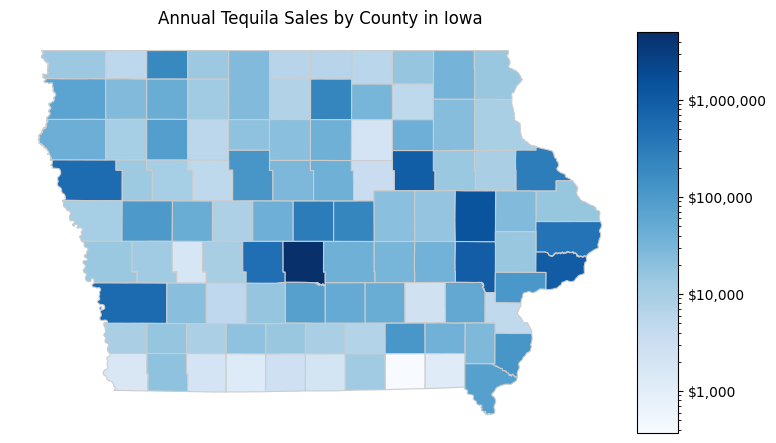

In [34]:
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 6))

# remove axis
ax.axis('off')

# add a title
ax.set_title('Annual Tequila Sales by County in Iowa', fontdict={'fontsize': '12', 'fontweight' : '30'})

# setting a variable that will call specificed column to be view on map
variable = 'sale_(dollars)'

# set the range for the choropleth
vmin, vmax = merged[variable].min(), merged[variable].max()

# create map
merged.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', legend=False, norm=colors.LogNorm(vmin=vmin, vmax=vmax))

# create colorbar as a legend
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=-1)

# removing scientific notation and adding dollar sign
fmt = '${x:,.0f}'
tick = ticker.StrMethodFormatter(fmt)
fig.colorbar(plt.cm.ScalarMappable(norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='Blues'), cax=cax, orientation='vertical', format=tick)
plt.savefig('/content/drive/MyDrive/Iowa Liquor /Visualisations/county_sales_chloropleth.png')  # saving plot
plt.show()


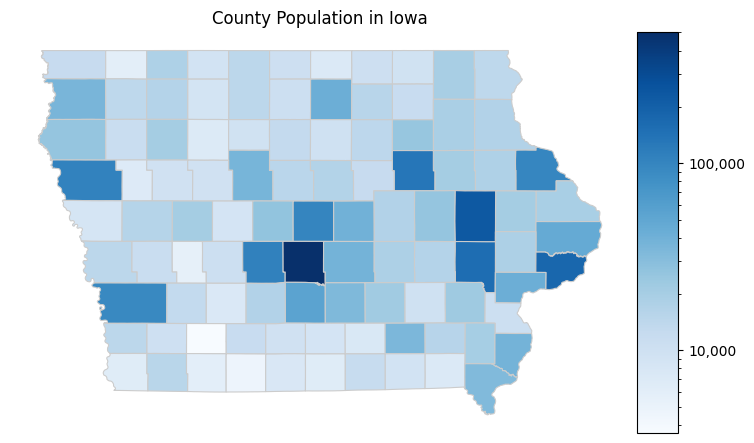

In [35]:
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 6))

# remove axis
ax.axis('off')

# add a title
ax.set_title('County Population in Iowa', fontdict={'fontsize': '12', 'fontweight' : '30'})

# setting a variable that will call specificed column to be view on map
variable = 'county_population'

# set the range for the choropleth
vmin, vmax = merged[variable].min(), merged[variable].max()

# create map
merged.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', legend=False, norm=colors.LogNorm(vmin=vmin, vmax=vmax))

# create colorbar as a legend
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=-1)

# removing scientific notation
fmt = '{x:,.0f}'
tick = ticker.StrMethodFormatter(fmt)
fig.colorbar(plt.cm.ScalarMappable(norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='Blues'), cax=cax, orientation='vertical', format=tick)
plt.savefig('/content/drive/MyDrive/Iowa Liquor /Visualisations/county_population_chloropleth.png')  # saving plot
plt.show()


The shading of counties in both of the above chloropleth maps are very similar and as expected, a larger population tends to mean more sales.